Authors: Leonardo De Clara, Riccardo Sena

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import norm,rv_discrete, invgamma

# ***Assignment 4***
Welcome to Assignment 4! In this assignment you are allowed to work 
***individually or in pairs***. It is worth 25 points in total. 

### ***Difference in this assignment***
You have two options: **either** you implement
1.   PyClone, or
2.   Particle Gibbs with Ancestral Sampling

**You are only allowed to do one of the above**. They are worth 25 points each. As usual, there is a 5 point minimum for passing this assignment (you need to pass all four assignments to be able to pass the course, see the grade chart on the Canvas course page for more details).

Submission details: Your submission should contain two pdf's. 

1. A pdf version of your filled out colaboratory on Canvas. You can do this by pressing `cmd/ctrl+p` (you know the drill from there).  
2. For Exercise 1, you need to hand in your hand-written solutions in a LaTeX pdf. We only accept solutions written in LaTeX, i.e. not Word or any other text editor. We recommend [Overleaf](https://overleaf.com), if you do not already have a favourite LaTeX editor (which is also [provided by KTH](https://intra.kth.se/en/it/programvara-o-system/programvara/installera/download/overleaf/overleaf-1.932755)).

# ***2. Particle Gibbs with Ancestral Sampling***

**Relevant resources:**

*   Andrieu, Christophe, Arnaud Doucet, and Roman Holenstein. "[Particle markov chain monte carlo methods.](https://www.stats.ox.ac.uk/~doucet/andrieu_doucet_holenstein_PMCMC.pdf)" Journal of the Royal Statistical Society: Series B (Statistical Methodology) 72.3 (2010): 269-342.
*   Lindsten, Fredrik, Michael I. Jordan, and Thomas B. Schon. "[Particle Gibbs with ancestor sampling.](https://www.jmlr.org/papers/volume15/lindsten14a/lindsten14a.pdf)" Journal of Machine Learning Research 15 (2014): 2145-2184.
*   Uppsala university's SMC course (see our lecture slides for refences).
*   Our lecture slides available on Canvas.


This is a follow-up task from Assigment 3. If you implemented the BPF, you will be able to reuse code from the last assignment (**if you did not implement the BPF before, you get the chance to implement it here instead**). There you were asked to find the parameters, $\theta$, that most likely generated the observations, $y_{1:T}$, by evaluating $p(y_{1:T}|\theta)$ for different choices of $\theta$ (recall the grid search).

Here you will learn a more elegant method for inferring probable parameters: via a combination of particle filtering and MCMC, hence termed PMCMC. This approach was first proposed by Andrieu et al. (in the first item above). You are asked to first implement the particle Gibbs (PG) method, which we discussed in the lectures, and then augment it using "ancestor sampling" (proposed in the second item). Throughout the assignment we will continue to work with the stochastic volatility (SV) model from the previous assignment, included here for completeness:

### **SV Model**
$$\begin{equation*}
        x_1 \sim \mathcal{N}(0, \frac{\sigma^2}{1 - \alpha ^2}),
\end{equation*}$$

$$\begin{equation*}
        x_n \sim \mathcal{N}(\alpha x_{n-1}, \sigma^2),
\end{equation*}$$

$$\begin{equation*}
        y_n \sim \mathcal{N}(0,  \beta^2\exp(x_{n})),
\end{equation*}$$

for $n=1,...,T$. We will assume that the parameters $\beta$ and $\sigma^2$ are unknown, while we assume that $\alpha=0.91$.

## **Conjugate priors**
We place inverse Gamma priors on the variance parameters:

\begin{align}
\sigma^2 & \sim \mathcal{IG}(a=0.01,b=0.01),
\\
\beta & \sim \mathcal{IG}(a=0.01,b=0.01),
\end{align}


where the the inverse Gamma pdf with parameters $(a,b)$ is given by
\begin{equation}
\mathcal{IG}(x|a,b)=\frac{b^a}{\Gamma(a)} x^{-a-1} \exp\left(-\frac{b}{x}\right)
\end{equation}
and $\Gamma$ is the Gamma function.

These priors are conjugate to the corresponding SV model pdf's and yield the following posteriors
\begin{equation}
    p(\sigma^2|x_{1:T}, \alpha) = \mathcal{IG}\left(\sigma^2|a + \frac{T}{2}, b + \frac{x_1^2(1 - \alpha^2)}{2} + \frac{1}{2}\sum^{T}_{n=2} (x_n - \alpha x_{n-1})^2\right),
\end{equation}

\begin{equation}
    p(\beta|x_{1:T}, y_{1:T}) = \mathcal{IG}\left(\beta|a + \frac{T}{2}, b + \frac{1}{2} \sum^T_{n=1}e^{-x_n}y_n^2\right)
\end{equation}

## **2.1 Implement the Particle Gibbs**
Implement a particle Gibbs sampler to compute the posterior distribution $p(\sigma^2,\beta|\alpha,y_{1:T})$. To do so, alternately sample from

*  $p(\sigma^2|\alpha,x_{1:T})$,
*  $p(\beta|x_{1:T},y_{1:T})$,
*  $p(x_{1:T}|\theta,y_{1:T})$ using conditional SMC.

To recall what a conditional SMC is, have a look at the SMC lecture slides (lecture 7 specifically), or the other resources.

Use a bootstrap particle filter (BPF) and resample at every iteration. Use the multinomial resampling scheme. **Hint:** read what you need to report as stated below, before you start coding.


In [2]:
def sample_xn(x, alpha, sigma):
    return np.random.normal(alpha * x, sigma)

def prob_xn(x, x_given, alpha, sigma):
    return norm.pdf(x, loc = alpha*x_given, scale = sigma)
    
def weights_pdf(y, x, beta):
    return norm.pdf(y, loc = 0, scale=beta*np.exp(x/2))
    
def multinomial(weights, K, N):
    return np.random.choice(K, N, p = weights)
    
def beta_post(a,b,x,y):
    """ Sample from the posterior distribution of beta given trajectory x_{1:T} and observations y_{1:T} """
    a_posterior = a + len(y)/2
    b_posterior = b + np.sum(np.exp(-x)* y**2)/2
    beta_squared = invgamma.rvs(a=a_posterior, scale=b_posterior)

    return np.sqrt(beta_squared), a_posterior, b_posterior

def sigma_post(a,b,alpha,x):
    """ Sample from the posterior distribution of sigma squared given trajectory x_{1:T} """
    a_posterior = a + len(x)/2
    b_posterior = b + (x[0]**2 * (1- alpha**2))/2 + np.sum((x[1:] - alpha*x[0:len(x)-1])**2)/(2)
    sigma_squared = invgamma.rvs(a=a_posterior, scale=b_posterior)

    return sigma_squared, a_posterior, b_posterior

def prior(a,b):
    dist = invgamma(a, scale = b)
    return dist.rvs(size=1)

In [3]:
def marginal_likelihood(weights):
    P = np.shape(weights)[0]
    S = np.shape(weights)[1]
    p = 1
    for i in range(P):
        s = 0
        for k in range(S):
            s = s + weights[i, k]
        p = p*s/S

    return p

In [4]:
def conditional_smc(K, T, alpha_param, sigma_param, beta_param, y_true, x_ref, resampling_scheme):

    x = np.zeros((T,K))
    w = np.zeros((T,K))
    w_normalized = np.zeros((T,K))

    x_n_hat_after = np.zeros(T)

    # set one particle as the reference
    x[:,K-1] = x_ref

    x[0,0:(K-1)] = np.random.normal(0, np.sqrt(sigma_param**2/(1-alpha_param**2)), K-1) # Initialize the particles

    #w[0,:] = weights_pdf(y_true[0],x[0,:], beta_param) # Compute the weights at t = 0
    w[0,:] = np.ones(K)
    w_normalized[0,:] = w[0,:]/np.sum(w[0,:])
    a = np.zeros((T,K),dtype=int)
    a[0,:] = np.arange(K)
    x_old = np.zeros((T,K))
    x_old[0,:] = x[0,:]

    for i in range(1,T):

        a[i, 0:(K-1)] = resampling_scheme(w_normalized[i-1,:], K, K-1)
        a[i, K-1] = K-1

        x[i,:K-1] = sample_xn(x[i-1,a[i,:K-1]], alpha_param, sigma_param)
        x_old[i,:] = x[i,:]
            
        x[0:i-1,0:(K-1)] = x[0:i-1,a[i,0:(K-1)]]

        w[i,:] = weights_pdf(y_true[i], x[i,:], beta_param)

        w_normalized[i,:] = w[i,:]/np.sum(w[i,:])
        
        x_n_hat_after[i] = np.sum(w_normalized[i,:]*x[i,:])

    final_ind = resampling_scheme(w_normalized[T-1,:], K, K)

    final_traj = x[:,final_ind[0]]

    likelihood = marginal_likelihood(w)

    return final_traj, x, x_old, a, likelihood

## **Report the distributions $p(\sigma^2|\alpha,x_{1:T})$ and $p(\beta^2 |x_{1:T},y_{1:T})$**
Use a trace plot to show that the PG has converged, and histograms to visualize the two distributions. Remember to discard the burn-in samples. If you did Assignment 3, how do these distributions correspond to your findings from the grid search? (You will not get point deduction if you have not done the grid search in assignment 3!) 

## **Report the approximate marginal likelihood**
From the lecture slides, we know how to compute the following marginal likelihood

\begin{equation}
p(y_{1:T}|\theta) = \int_{x_{1:T}} p(y_{1:T}|x_{1:T}, \theta) p(x_{1:T}|\theta) dx_{1:T} \approx \prod_{i=1}^T \sum_k\frac{1}{K} p(y_i|x_i^k, \theta).
\end{equation}

Use the PG sampler to compute the marginal likelihood, averaged over your MCMC iterations.

**Motivate why this is an approximation of the marginal likelhood, $p(y_{1:T})$. How is $p(y_{1:T})$ different from $p(y_{1:T}|\theta)$?**


<function matplotlib.pyplot.show(close=None, block=None)>

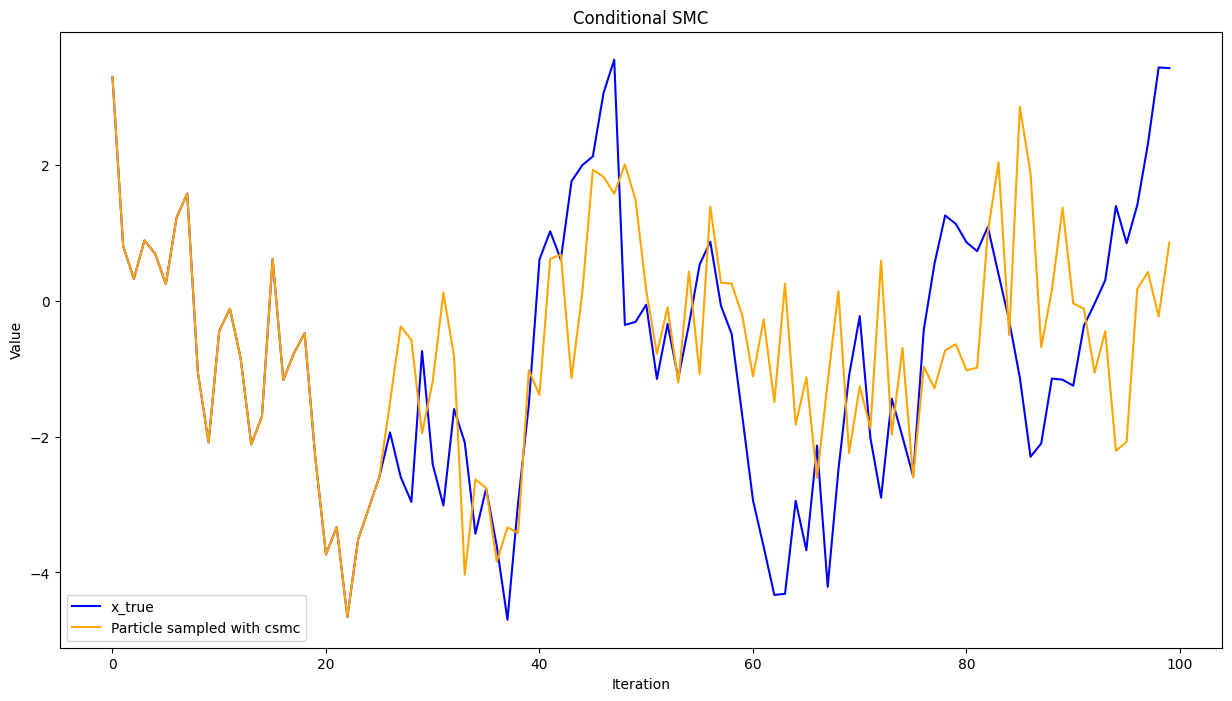

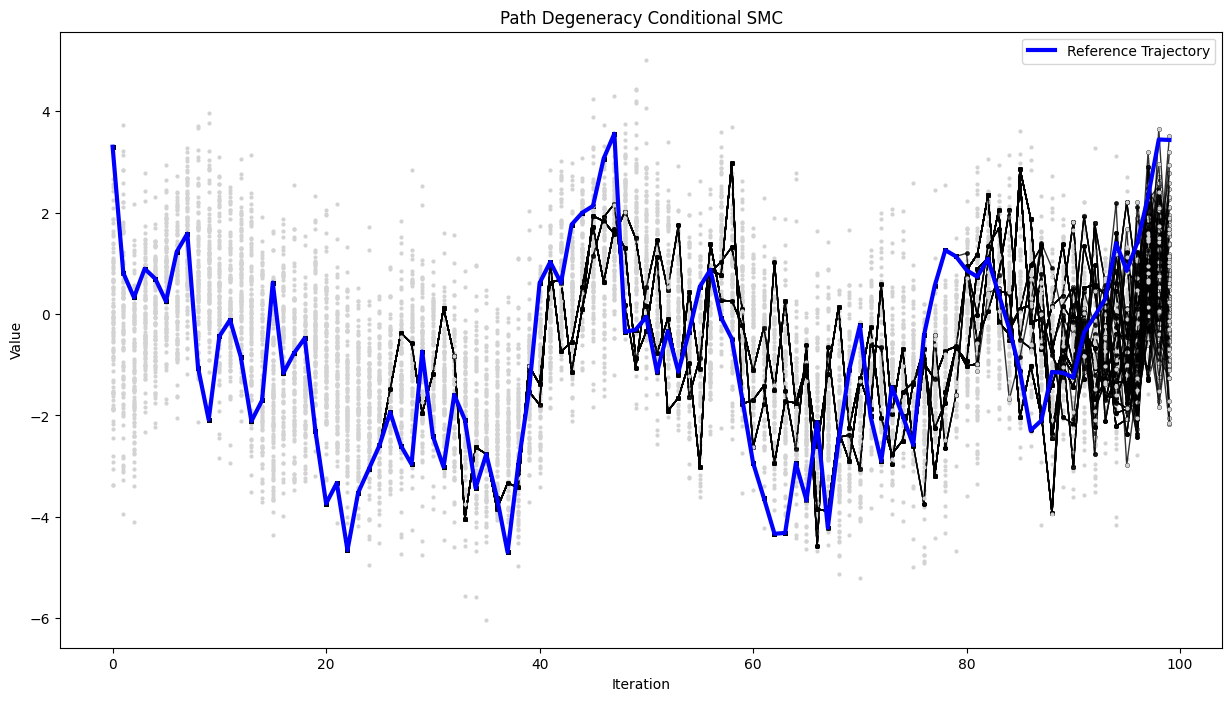

In [52]:
# testing the conditional smc algorithm
np.random.seed(187)
T = 100
K = 100
x_ref = np.zeros(T)
y_true = np.zeros(T)
x_ref[0] = np.random.normal(0,np.sqrt(1/(1-0.91**2))) # Sample reference trajectory from the prior
for t in range(1,T):
    x_ref[t] = np.random.normal(0.91*x_ref[t-1],1) # particle value at time t given the previous one
    y_true[t] = np.random.normal(0, scale = np.sqrt(0.64**2 * np.exp(x_ref[t])))

x_final,xx,xx_old,_,_ = conditional_smc(K,T,0.85,0.8,0.55,y_true,x_ref,multinomial)

plt.figure(figsize=(15,8))
plt.plot(x_ref, color = 'blue', label = 'x_true')
plt.plot(x_final, color = 'orange', label='Particle sampled with csmc')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Conditional SMC')
plt.show

plt.figure(figsize=(15,8))
for k in range(K-1):
    plt.plot(xx[:,k],'-', color='black', marker='.', markersize=5, lw=1,alpha=0.8, antialiased=True)
    plt.plot(xx_old[:,k], 'o', color = 'lightgrey', markersize = 2)
plt.plot(xx[:,K-1], linewidth = 3, color = 'blue', label = 'Reference Trajectory')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Path Degeneracy Conditional SMC')
plt.show

In [58]:
def pg(M, T, K, alpha_p, start, y, a, b, beta0, sigma0, verbose = False):

    x_r = np.zeros((T,M))

    betas = np.zeros(M)
    sigmas = np.zeros(M)
    likelihoods = np.zeros(M-1)


    betas[0] = beta0
    sigmas[0] = sigma0

    x_r[:,0] = start
    plt.figure(figsize = (20,10))

    for m in range(1,M):
        #plt.plot(x_r[:,m-1], label = "it "+str(m-1))
        #plt.legend()
        final_trajectories = np.zeros((T,K))
        x_old = np.zeros((T,K))
        ancestors = np.zeros((T,K))
        betas[m],__,__ =  beta_post(a, b, x_r[:,m-1], y)
        sigmas[m],__,__ = sigma_post(a, b, alpha_p, x_r[:,m-1])
        if (verbose):
            print("Beta is: ", betas[m])
            print("Sigma is: ", sigmas[m])
        x_r[:,m],final_trajectories, x_old, ancestors, likelihoods[m-1] = conditional_smc(K=K, T=T, alpha_param=alpha_p, 
                                                            sigma_param=sigmas[m], beta_param=betas[m], y_true=y, x_ref=x_r[:,m-1],
                                                             resampling_scheme= multinomial)
        #plt.plot(x_r[:,m])

    return x_r, betas, sigmas, final_trajectories, x_old, ancestors, likelihoods


In [59]:
np.random.seed(187)
# load observations.npy from the SMC module on Canvas
observations = np.load('observations.npy')

M = 1000
K = 30
T = 100
a = 0.01
b = 0.01

alph = 0.91
beta0 = 0.1
sigma0 = 0.02
likelihoods = np.zeros(M-1)

x_r = np.zeros((T,M))
x_start = np.zeros(T)
x_start[0] = np.random.normal(0, np.sqrt(sigma0/(1-alph**2)))

for i in range(1,T):
    x_start[i] = np.random.normal(alph*x_start[i-1], np.sqrt(sigma0))

x_r,betas,sigmas,traj, x_old, ancestors, likelihoods = pg(M=M, K=K, T=T, alpha_p=alph, start=x_start, y=observations, a=a, b=b, beta0=beta0,
                                                          sigma0=sigma0)



<Figure size 2000x1000 with 0 Axes>

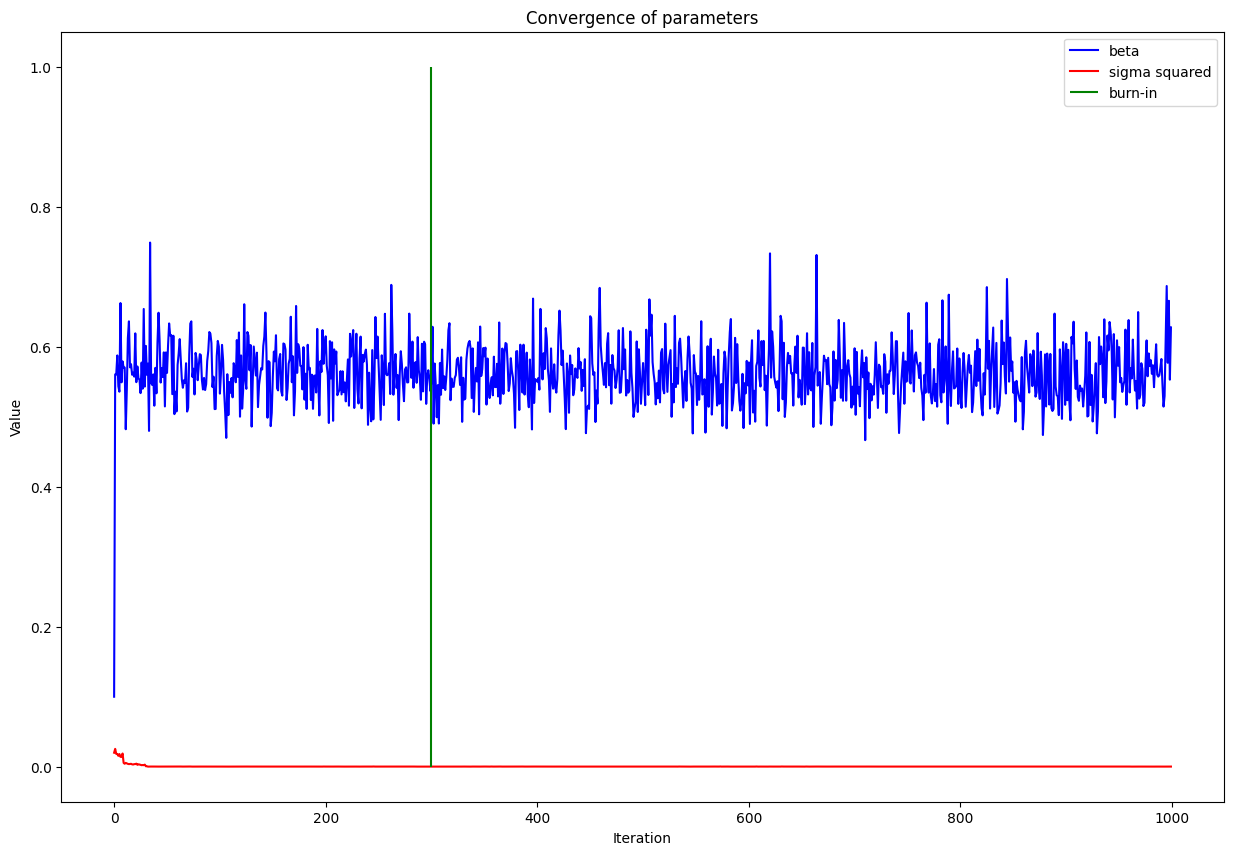

Average beta: 0.56
Average sigma squared: 0.00044


In [40]:
burn_in = 0.3
betas_post_burnin = betas[int(burn_in*M):]
sigma_squareds_post_burnin = sigmas[int(burn_in*M):]

plt.figure(figsize=(15,10))
plt.plot(betas, color='blue', label='beta')
plt.plot(sigmas, color='red', label='sigma squared')
plt.vlines(burn_in*M,0,1,color='green',label='burn-in')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Convergence of parameters')
plt.legend()
plt.show()
print("Average beta: {:.2f}".format(np.mean(betas)))
print("Average sigma squared: {:.5f}".format(np.mean(sigmas)))

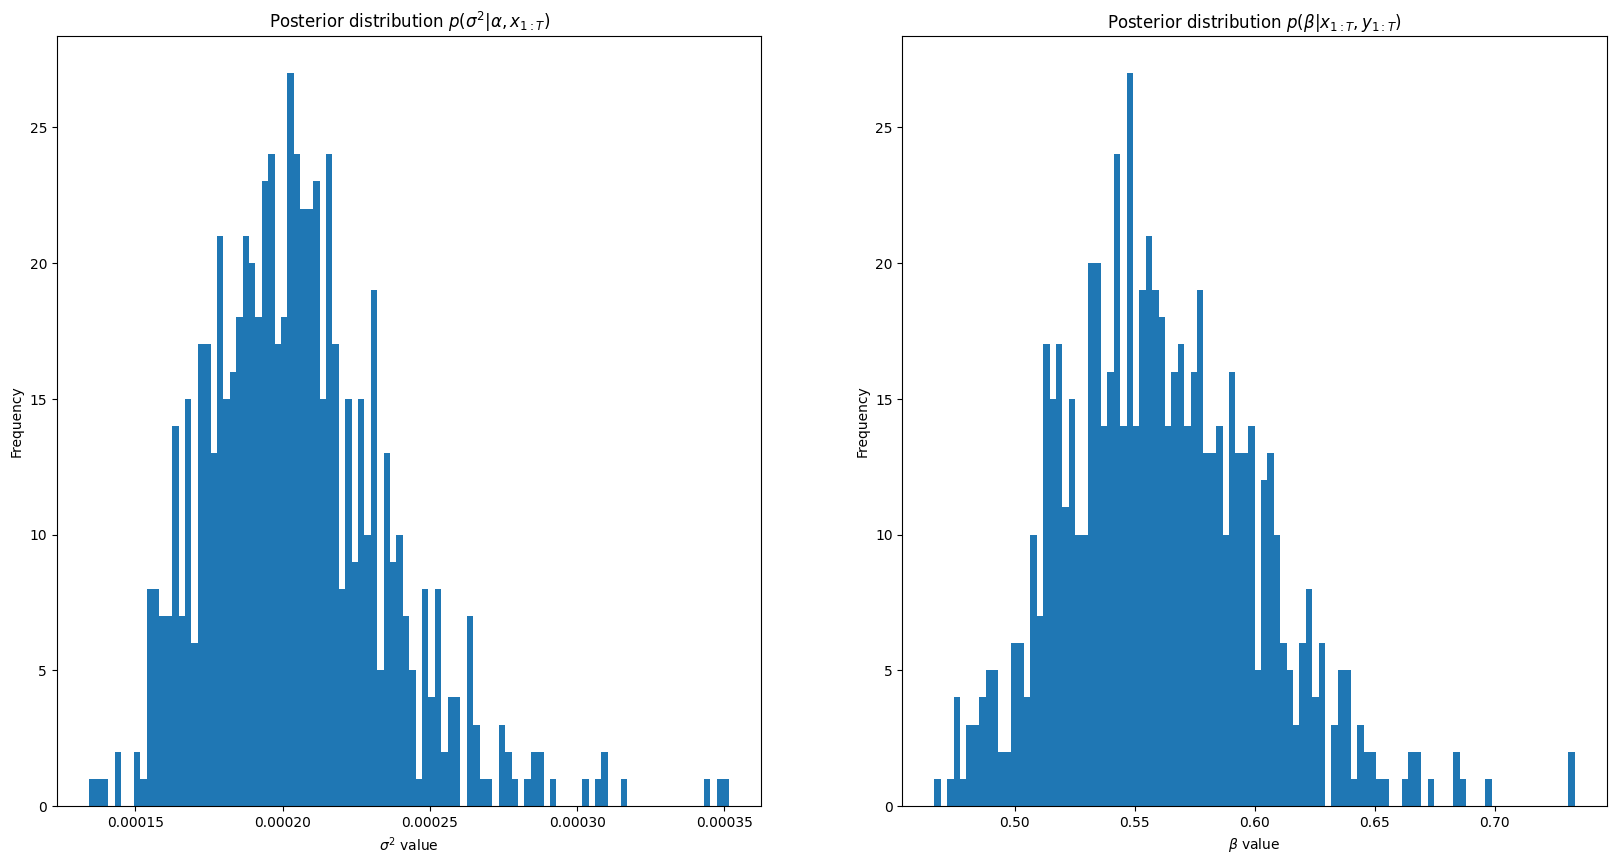

In [42]:
#Sigma and beta posterior distributions

fig,axs=plt.subplots(1,2,figsize=(20,10))
axs[0].hist(sigma_squareds_post_burnin, bins=100)
axs[0].set_title('Posterior distribution $p(\sigma^2|\\alpha,x_{1:T})$')
axs[0].set_xlabel('$\sigma^2$ value')
axs[0].set_ylabel('Frequency')
axs[1].hist(betas_post_burnin,bins=100)
axs[1].set_title('Posterior distribution $p(\\beta |x_{1:T},y_{1:T})$')
axs[1].set_xlabel('$\\beta$ value')
axs[1].set_ylabel('Frequency')
plt.show()

The trace plots allow to see how the values obtained for $\sigma^2$ and $\beta$ change over time, clearly showing that the Particle Gibbs algorithm converges to a stationary distribution in both cases within a significantly small number of iterations.

From the histograms plotted above we can see that the posterior distribution of $\beta$ peaks at around 0.56, which is close to the true value used in assignment 3 and also to the value found through grid search. The posterior distribution of $\sigma^2$, on the other hand, peaks at a lower value when compared to grid search's result (0.1), but further tests would be needed to determine which one is closer to the true value since we set the lower bound for grid search at 0.1.

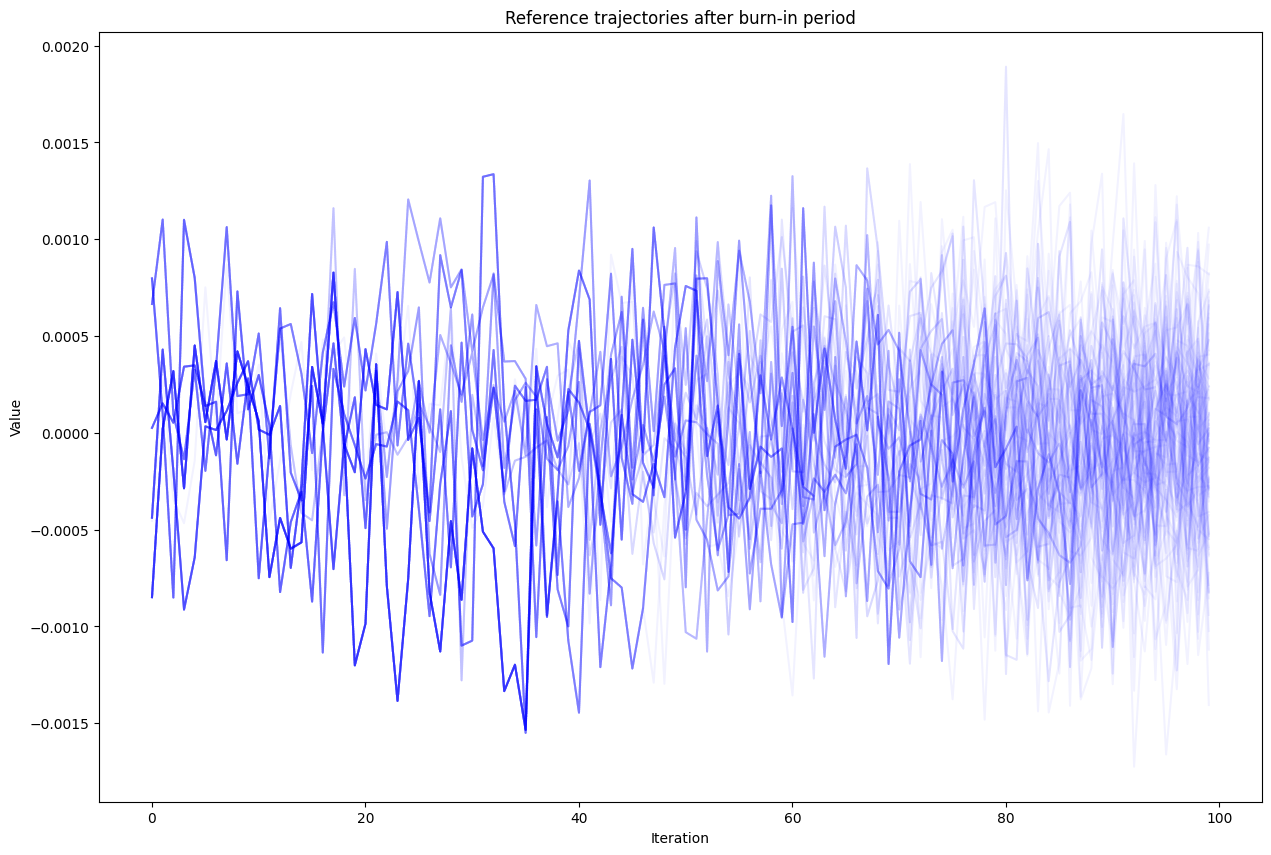

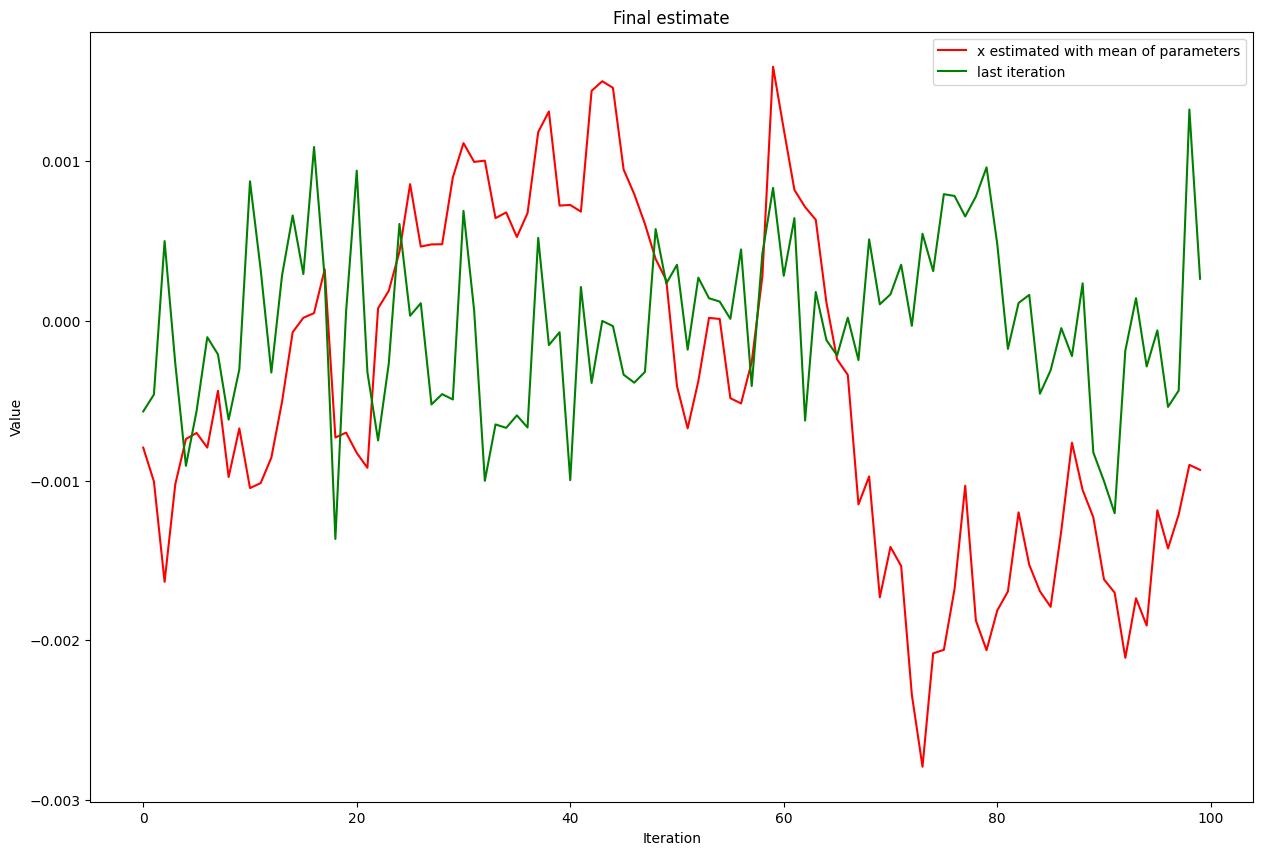

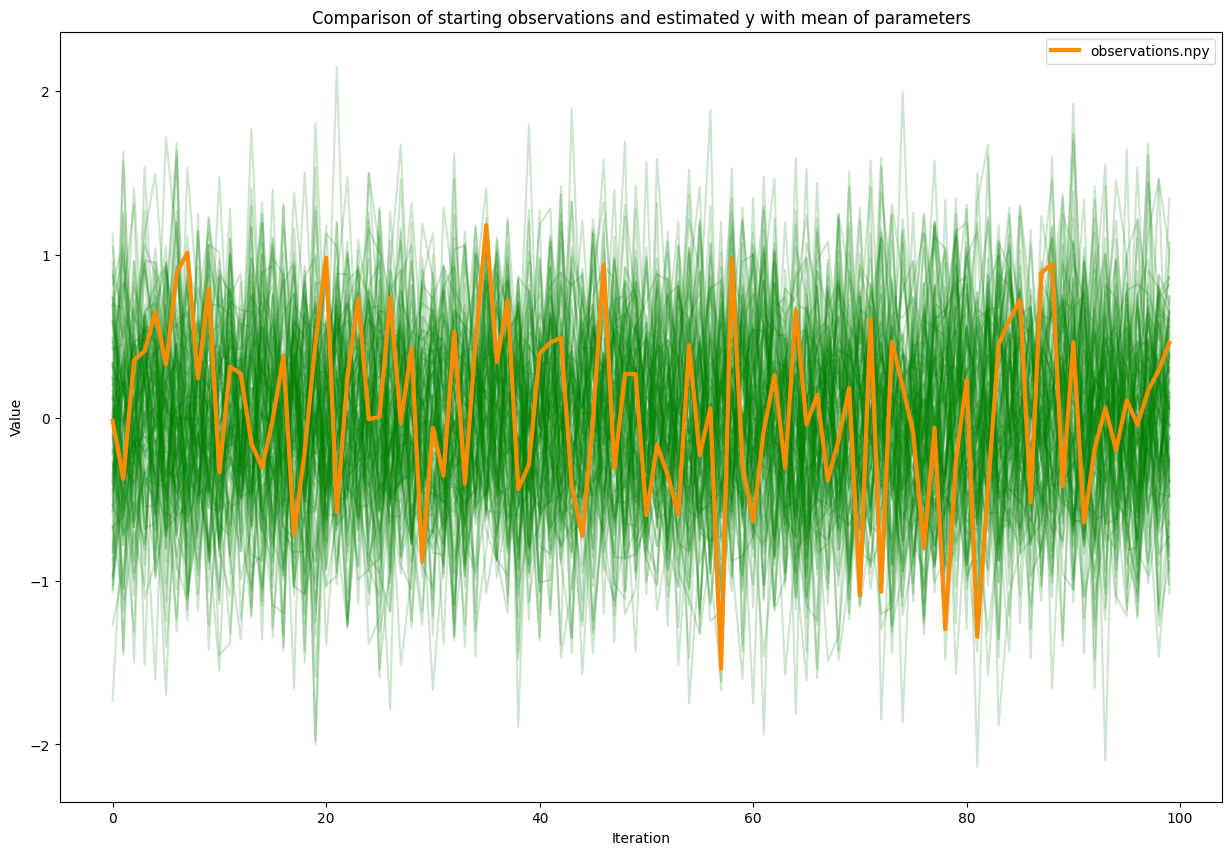

In [51]:
np.random.seed(44)
plt.figure(figsize=(15,10))
plt.title('Reference trajectories after burn-in period')
x_refs_post_burn_in = x_r[:,int(burn_in*M):]
for m in range(len(x_refs_post_burn_in)):
    plt.plot(x_refs_post_burn_in[:,m], color = 'blue', alpha = 0.05)
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.show()

# let's compare with a trajectory generated by the estimated parameters
T = 100
N = 100
x_ref = np.zeros(T)
y_true = np.zeros((T,N))
x_ref[0] = np.random.normal(0,np.sqrt(np.mean(sigmas)**2/(1-0.91**2))) 
y_true[0,:] = np.random.normal(0, scale = np.sqrt(np.mean(betas)**2 * np.exp(x_ref[t])), size = N)
for t in range(1,T):
    x_ref[t] = np.random.normal(0.91*x_ref[t-1],np.mean(sigmas)) # particle value at time t given the previous one
    y_true[t,:] = np.random.normal(0, scale = np.sqrt(np.mean(betas)**2 * np.exp(x_ref[t])), size = N)


plt.figure(figsize=(15,10))
plt.plot(x_ref, color = 'red', label = 'x estimated with mean of parameters')
plt.plot(x_r[:,-1], color = 'green', label = 'last iteration')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Final estimate')
plt.legend()
plt.show()

# also let's compare the true y with the observations obtained
plt.figure(figsize=(15,10))
plt.title('Comparison of starting observations and estimated y with mean of parameters')
for n in range(N):
   plt.plot(y_true[:,n], color='green', alpha = 0.2)
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.plot(observations, color='darkorange', label = 'observations.npy', linewidth = 3)
plt.legend()
plt.show()

The plots above show some of the effects of the use of the PG algorithm: the first exhibits how the reference trajectories explore state space, while the second one compares the last iteration's reference trajectory with a trajectory obtained through the use of the mean of the sampled parameters. 
The third plot shows the difference between the true observations given as input and the observations obtained by sampling from the emission distribution using the mean of the sampled parameters.

The mean marginal likelihood value is:  6.531234045811074e-37


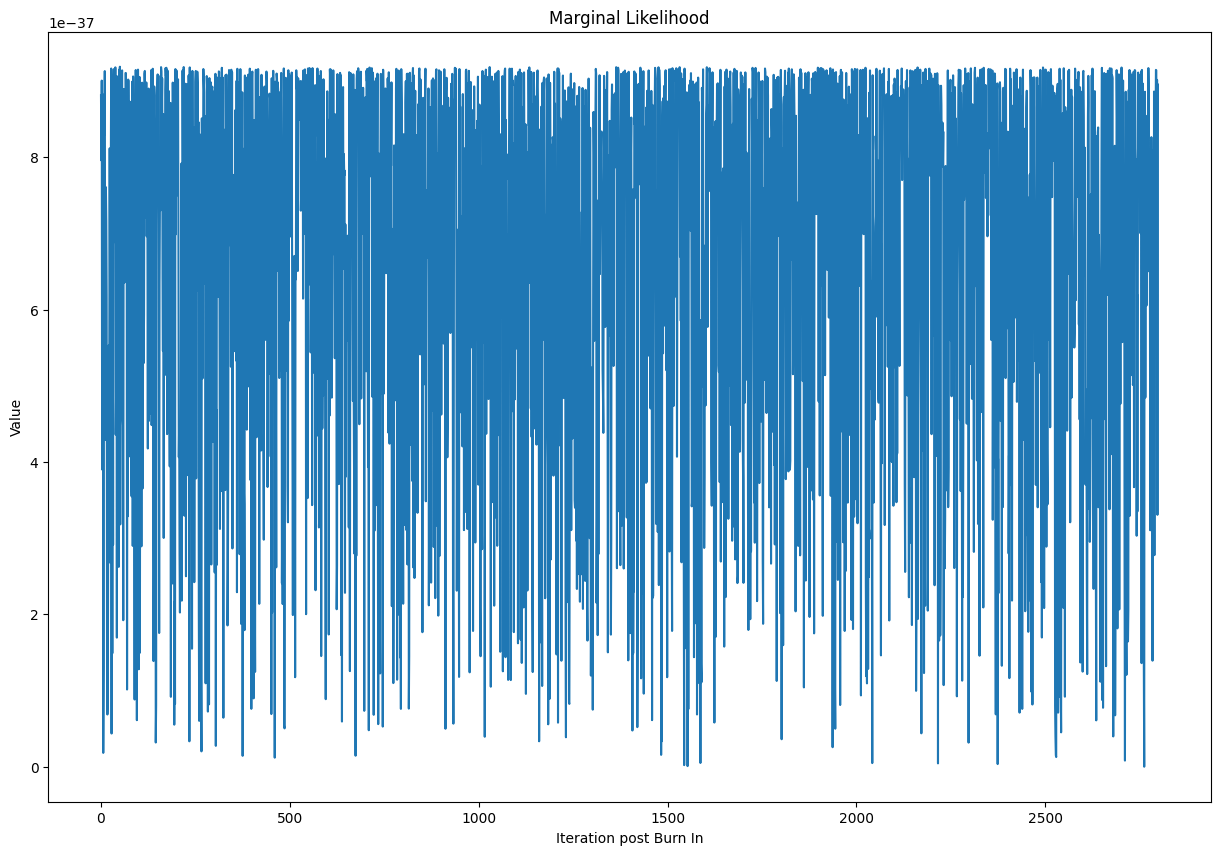

In [12]:
# we consider the likelihoods after the burn in period

likelihoods_post_burnin = likelihoods[int(burn_in*M):]

plt.figure(figsize = (15, 10))
plt.plot(likelihoods_post_burnin)
plt.title('Marginal Likelihood')
plt.xlabel('Iteration post Burn In')
plt.ylabel('Value')

print("The mean marginal likelihood value is: ", np.sum(likelihoods_post_burnin)/len(likelihoods_post_burnin))

*Answer here*
The marginal likelihood obtained through Particle Gibbs is an approximation of the true likelihood, since it is computed by averaging over the MCMC iterations. Furthermore, every iteration of PG's marginal likelihood depends on a different set of parameters, which are sampled from the posterior distribution of $\sigma^2$ and $\beta$.

When compared to assignment 3's marginal likelihood results we can see the values obtained through PG are similar to the grid search ones.

## **Visualize the path degeneracy**
Using the particle filter from the final MCMC iteration, plot the path degeneracy in the particle filter. Below we provide some code to help you visualize the path degeneracy. 

**Hint:** when you code your BPF, make sure to keep track of the ancestry and the inferred latent states at each time step. I.e. at each time step $n$, book keep the ancestors of the particles in the system, $k$ or $a^k$, and their corresponding $x_n$. This way you can go "backwards in time" and observe the path degeneracy.

In [13]:
def particleGeneologyAll(title, particles, B, x_true=None, x_rs=None): 
    # particle: the inferred latent states at each time step shape=(num_particles, total_time)
    # B: the complete ancestry shape=(num_particles, total_time)  
    plt.figure(figsize=(14, 8)) 
    N, T = particles.shape 
    x_matrix = np.arange(T)

    # plot all the particles first
    for j in range(N): 
        plt.scatter(x_matrix, particles[j], color="lightgrey", s=5) 
     
    # plot geneology of survived 
    x_star = np.zeros(T) 
    for j in range(N): 
        curr = j 
        i = T-1 
        x_star[i] = particles[j, T-1] 
        for t in reversed(range(T-1)): 
            if curr == N - 1 and j != N - 1: 
                # Originated from reference particle 
                break 
            indx = B[curr, t+1] 
            x_star[i-1] = particles[indx, t] 
            curr = indx 
            i -= 1 
        x_dim = range(t, T) 
         
        if j == N - 1 and x_rs is None: 
            plt.plot(x_dim, x_star, color='blue', linewidth=3) 
        else: 
            plt.plot(x_dim[1:], x_star[t+1:], color='black', marker='.', markersize=10, lw=1,
                    alpha=0.8, antialiased=True)
     
    if x_rs is not None: 
        for t, resampled, original in zip(range(T), x_rs[0], x_rs[1]): 
            plt.plot((t-1, t), (resampled, original), color='blue', linewidth=3)
     
    if x_true is not None:  
        plt.plot(x_true, color='g', linewidth=3) 
     
    plt.title(title) 
    plt.ylabel('Volatility') 
    plt.xlabel('t') 
    plt.show() 

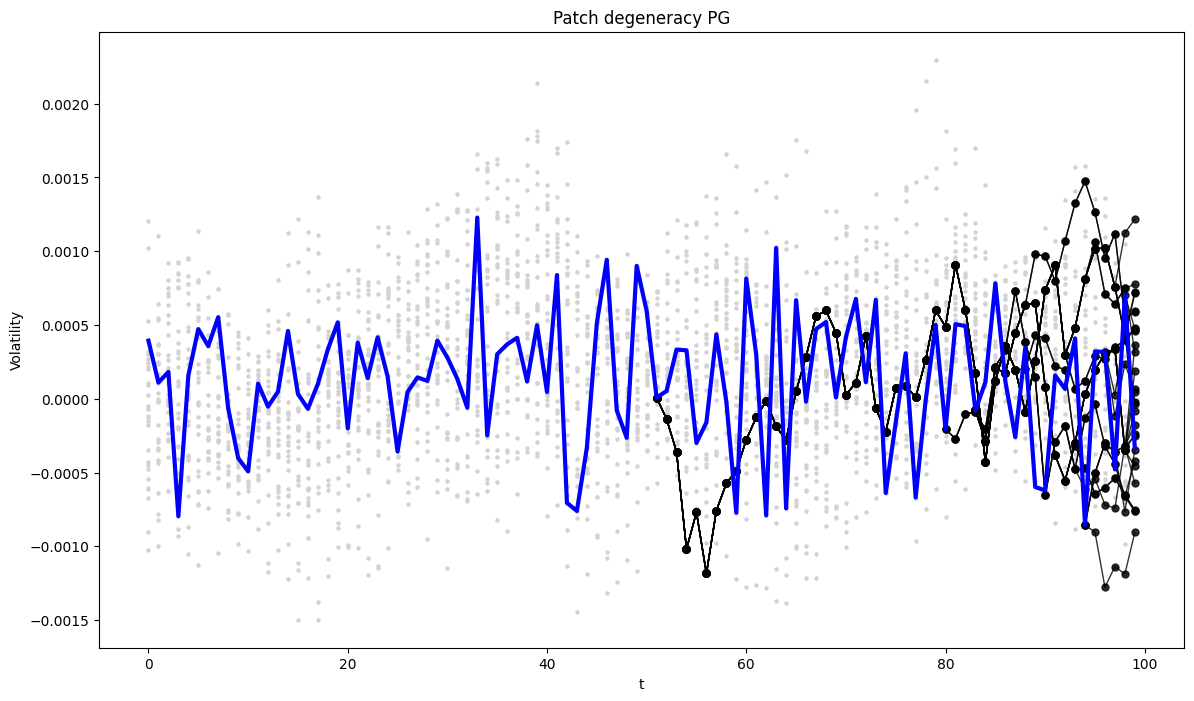

In [14]:
#x_old[:,K-1] = x_r[:,M-1]
particleGeneologyAll("Patch degeneracy PG", np.transpose(x_old), np.transpose(ancestors), x_true=None, x_rs=None)

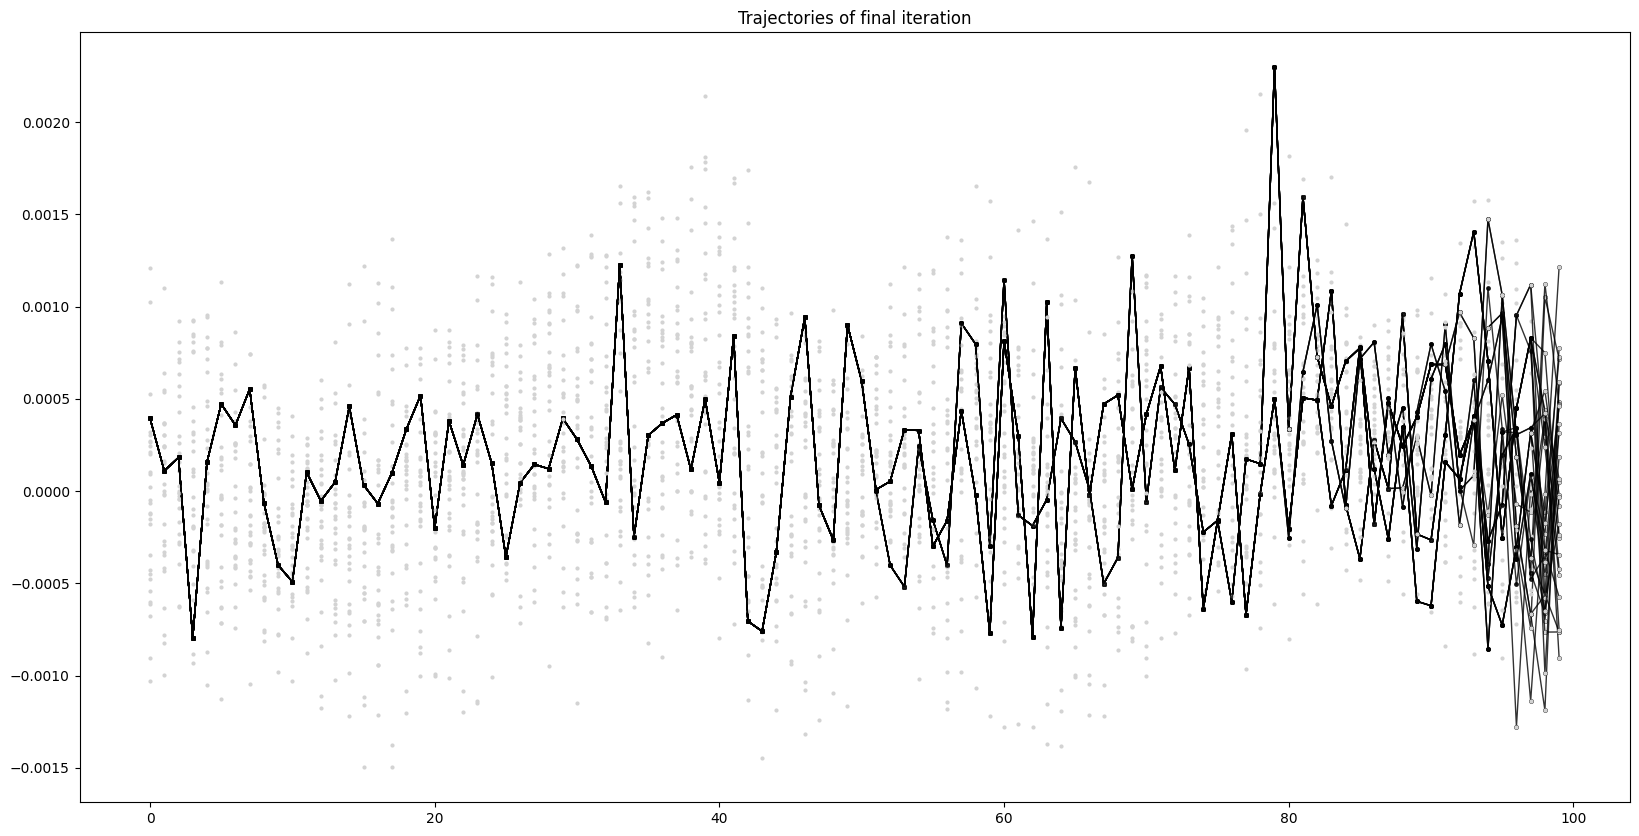

In [15]:
plt.figure(figsize=(20,10))
plt.title('Trajectories of final iteration')
for i in range(K-1):
    plt.plot(traj[:,i],'-', color='black', marker='.', markersize=5, lw=1,alpha=0.8, antialiased=True)
    plt.plot(x_old[:,i], 'o', color = 'lightgrey', markersize = 2)
plt.xlabel('Iteration')
plt.ylabel('Value')

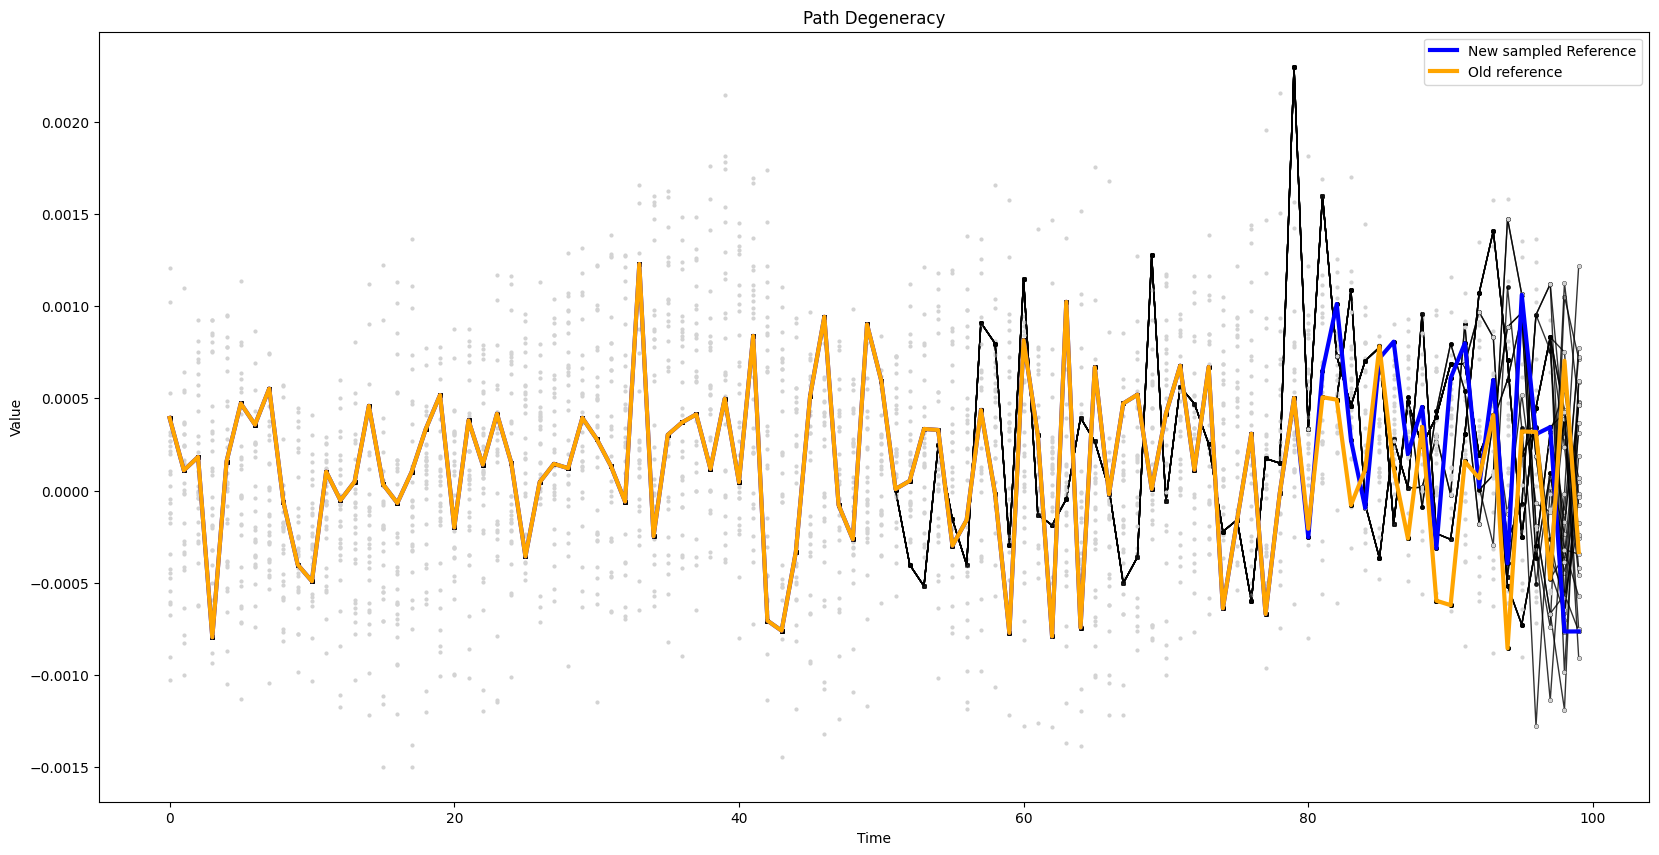

In [16]:
plt.figure(figsize=(20,10))
for i in range(K-1):
    plt.plot(traj[:,i],'-', color='black', marker='.', markersize=5, lw=1,alpha=0.8, antialiased=True)
    plt.plot(x_old[:,i], 'o', color = 'lightgrey', markersize = 2)

#traj[:,K-1] = x_r[:,M-1]
plt.plot(x_r[:,M-1], color='blue', linewidth=3, label = 'New sampled Reference')
plt.plot(traj[:,K-1], color='orange', linewidth=3, label = 'Old reference')
plt.legend()
plt.title('Path Degeneracy')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.show()

We can see that the path degeneracy is very high, since the particles are all concentrated around a single ancestor. 

## **2.2 Implement the Particle Gibbs with Ancestral Sampling (PGAS)**
In "[Particle Gibbs with ancestor sampling](https://www.jmlr.org/papers/volume15/lindsten14a/lindsten14a.pdf)" they point out that the resulting particle system in the PG sampler is undesirably biased towards the reference trajectory. This affects the path degeneracy in the way that most particles are resampled from the reference trajectory.

PGAS is a relatively small update of the PG sampler but comes with great benefits in terms of path degeneracy. Update your PG sampler above into the PGAS, repeat the following two exercises:

*   **Report the approximate marginal likelihood**
*   **Visualize the path degeneracy**



In [17]:
def ancestor_sampling(K, T, alpha_param, sigma_param, beta_param, y_true, x_ref, resampling_scheme):

    x = np.zeros((T,K))
    w = np.zeros((T,K))
    w_normalized = np.zeros((T,K))

    x_n_hat_after = np.zeros(T)

    # set one particle as the reference
    x[:,K-1] = x_ref

    x[0,0:(K-1)] = np.random.normal(0, np.sqrt(sigma_param**2/(1-alpha_param**2)), K-1) # Initialize the particles

    #w[0,:] = weights_pdf(y_true[0],x[0,:], beta_param) # Compute the weights at t = 0
    w[0,:] = np.ones(K)
    w_normalized[0,:] = w[0,:]/np.sum(w[0,:])
    a = np.zeros((T,K),dtype=int)
    a[0,:] = np.arange(K)
    x_old = np.zeros((T,K))
    x_old[0,:] = x[0,:]

    weights_reference = np.zeros((T, K-1))
    weights_reference_n = np.zeros((T,K-1))

    for i in range(1,T):

        a[i, 0:(K-1)] = resampling_scheme(w_normalized[i-1,:], K, K-1)

        for j in range(K-1):
            weights_reference[i-1,j] = w_normalized[i-1,j] * prob_xn(x[i,K-1], x[i-1,j], alpha_param, np.sqrt(sigma_param))
        weights_reference_n[i-1,:] = weights_reference[i-1,:]/np.sum(weights_reference[i-1,:])
        
        #print('Sum is: ', np.sum(weights_reference_n[i-1,:]))
        #print(weights_reference_n[i-1,:])
        a[i, K-1] = resampling_scheme(weights_reference_n[i-1,:], K-1, 1)

        x[i-1, K-1] = x[i-1, a[i,K-1]]

        x[i,:K-1] = sample_xn(x[i-1,a[i,:K-1]], alpha_param, sigma_param)
        x_old[i,:] = x[i,:]
            
        x[0:i-1,0:(K-1)] = x[0:i-1,a[i,0:(K-1)]]

        w[i,:] = weights_pdf(y_true[i], x[i,:], beta_param)

        w_normalized[i,:] = w[i,:]/np.sum(w[i,:])
        
        x_n_hat_after[i] = np.sum(w_normalized[i,:]*x[i,:])

    final_ind = resampling_scheme(w_normalized[T-1,:], K, K)

    final_traj = x[:,final_ind[0]]

    likelihood = marginal_likelihood(w)

    return final_traj, x, x_old, a, likelihood

In [18]:
def pgas(M, T, K, alpha_p, start, y, a, b, beta0, sigma0, verbose = False):

    x_r = np.zeros((T,M))

    betas = np.zeros(M)
    sigmas = np.zeros(M)
    likelihoods = np.zeros(M-1)


    betas[0] = beta0
    sigmas[0] = sigma0

    x_r[:,0] = start
    plt.figure(figsize = (20,10))

    for m in range(1,M):
        #plt.plot(x_r[:,m-1], label = "it "+str(m-1))
        #plt.legend()
        final_trajectories = np.zeros((T,K))
        x_old = np.zeros((T,K))
        ancestors = np.zeros((T,K))
        betas[m],__,__ =  beta_post(a, b, x_r[:,m-1], y)
        sigmas[m],__,__ = sigma_post(a, b, alpha_p, x_r[:,m-1])
        if (verbose):
            print("Beta is: ", betas[m])
            print("Sigma is: ", sigmas[m])
            print('Iteration: ', m)
        x_r[:,m],final_trajectories, x_old, ancestors, likelihoods[m-1] = ancestor_sampling(K=K, T=T, alpha_param=alpha_p, 
                                                            sigma_param=sigmas[m], beta_param=betas[m], y_true=y, x_ref=x_r[:,m-1],
                                                             resampling_scheme= multinomial)
        #plt.plot(x_r[:,m])

    return x_r, betas, sigmas, final_trajectories, x_old, ancestors, likelihoods


In [ ]:
np.random.seed(187)
# load observations.npy from the SMC module on Canvas
observations = np.load('observations.npy')

M = 1000
K = 30
T = 100
a = 0.01
b = 0.01


likelihoods_as = np.zeros(M-1)

x_r_as = np.zeros((T,M))


x_r_as,betas_as,sigmas_as,traj_as, x_old_as, ancestors_as, likelihoods_as = pgas(M=M, K=K, T=T, alpha_p=alph, start=x_start,
                                                                                  y=observations, a=a, b=b, beta0=beta0,sigma0=sigma0)


betas_as_post_burnin = betas_as[int(burn_in*M):]
sigma_squareds_as_post_burnin = sigmas_as[int(burn_in*M):]

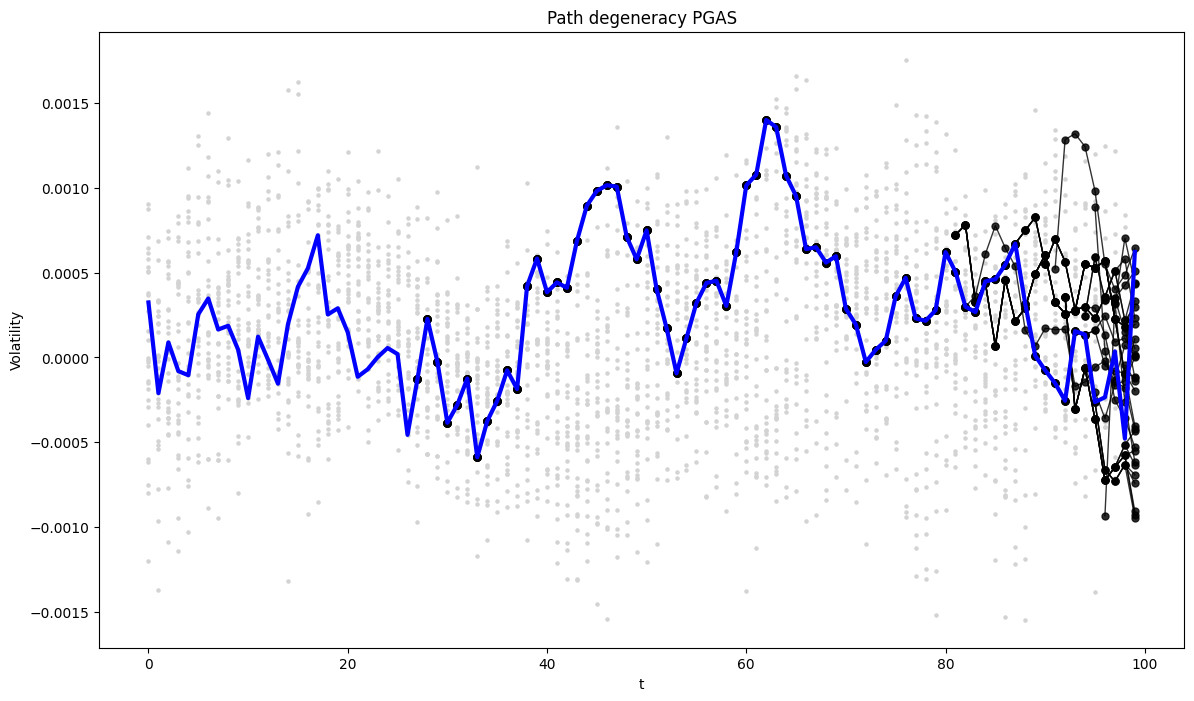

In [57]:
particleGeneologyAll("Path degeneracy PGAS", np.transpose(x_old_as), np.transpose(ancestors_as), x_true=None, x_rs=None)

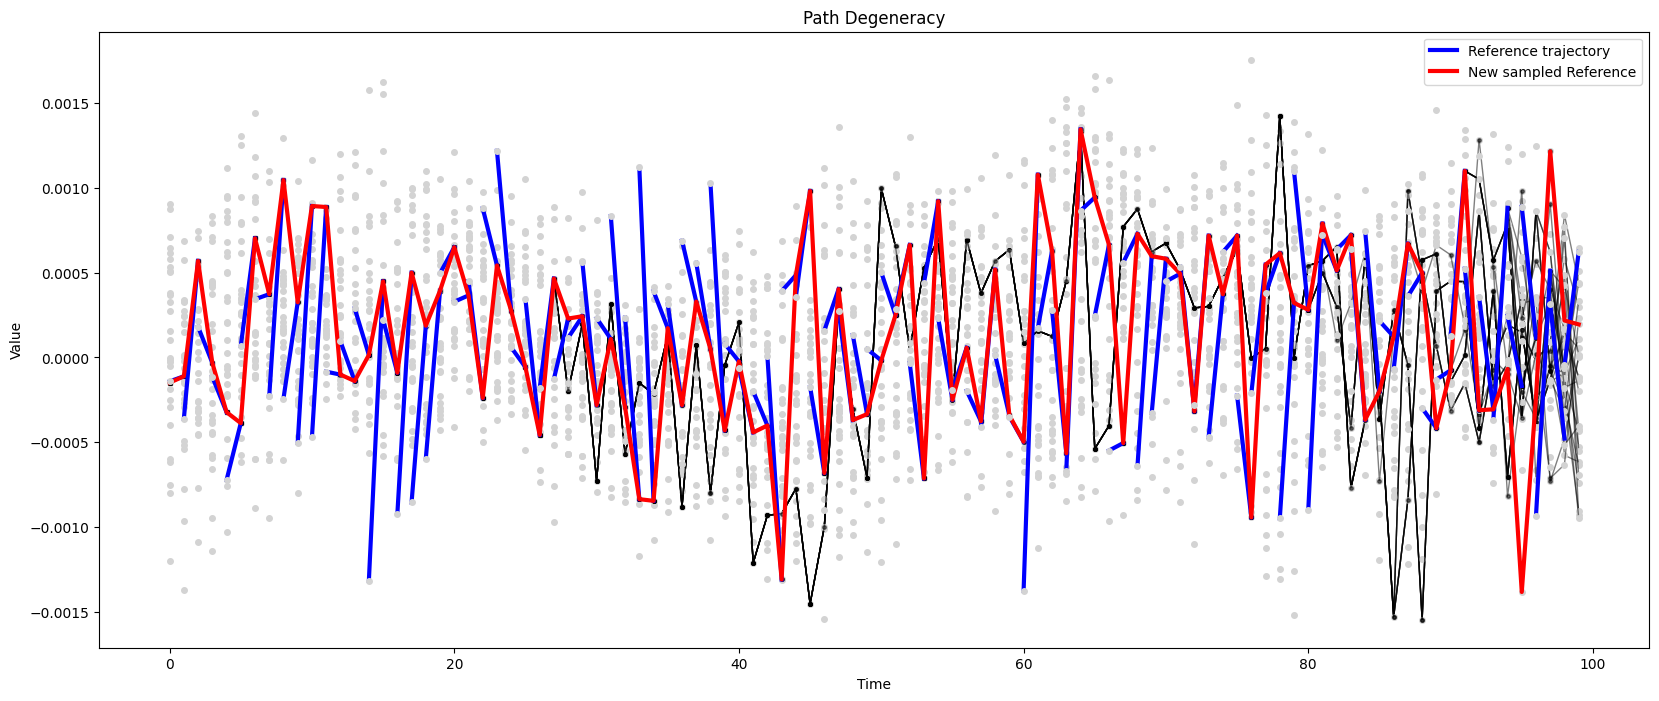

In [46]:
plt.figure(figsize=(20,8))
for i in range(K-1):
    plt.plot(traj_as[:,i],'-', color='black', marker='.', markersize=5, lw=1,alpha=0.5, antialiased=True)
    plt.plot(x_old_as[:,i], 'o', color = 'lightgrey', markersize = 4)

#traj[:,K-1] = x_r[:,M-1]
for t in range(T-1):
    plt.plot([t,t+1],[x_r_as[t,M-2], traj_as[t+1,K-1]], color='blue', linewidth=3)
plt.plot(0, x_r_as[0,M-2], color = 'blue', linewidth=3, label = 'Reference trajectory')

plt.plot(x_r_as[:,M-1], color='red', linewidth=3, label = 'New sampled Reference')
plt.plot(x_old_as[:,K-1], 'o', color = 'lightgrey', markersize = 4)
plt.legend()
plt.title('Path Degeneracy')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

Compared to the PG algorithm, the PGAS algorithm shows a lower path degeneracy, as shown in the plot above. This is due to the fact that the ancestor sampling allows to "chop up" the ancestral history of the reference trajectory.

The mean marginal likelihood value is:  6.360588587674041e-37


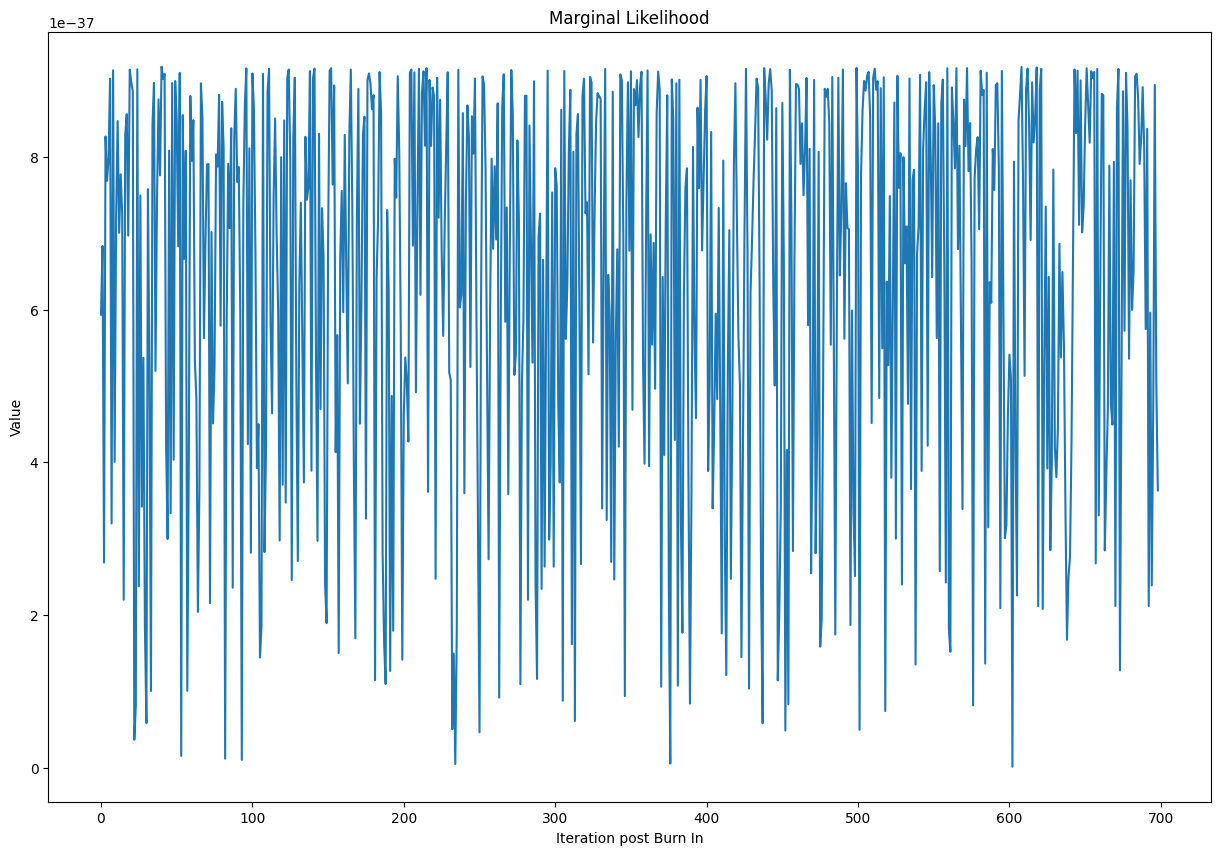

In [47]:
# mean marginal likelihood
burn_in = 0.3
likelihoods_post_burnin_as = likelihoods_as[int(burn_in*M):]

plt.figure(figsize = (15, 10))
plt.plot(likelihoods_post_burnin_as)
plt.title('Marginal Likelihood')
plt.xlabel('Iteration post Burn In')
plt.ylabel('Value')

print("The mean marginal likelihood value is: ", np.sum(likelihoods_post_burnin_as)/len(likelihoods_post_burnin_as))

Text(0.5, 1.0, 'Posterior distribution $p(\\sigma^2|\\alpha,x_{1:T})$ (PGAS)')

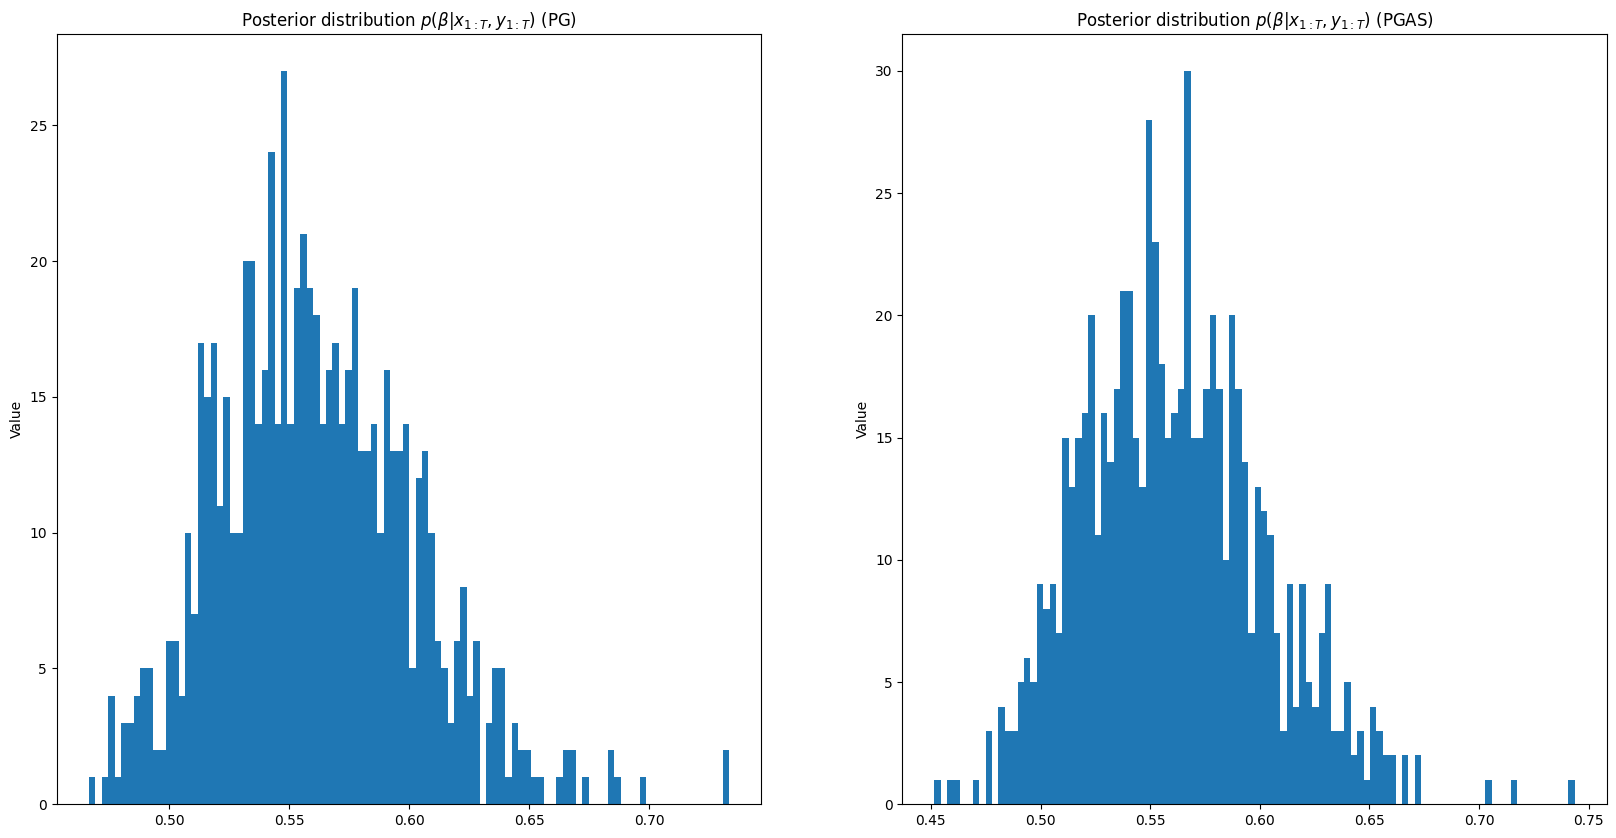

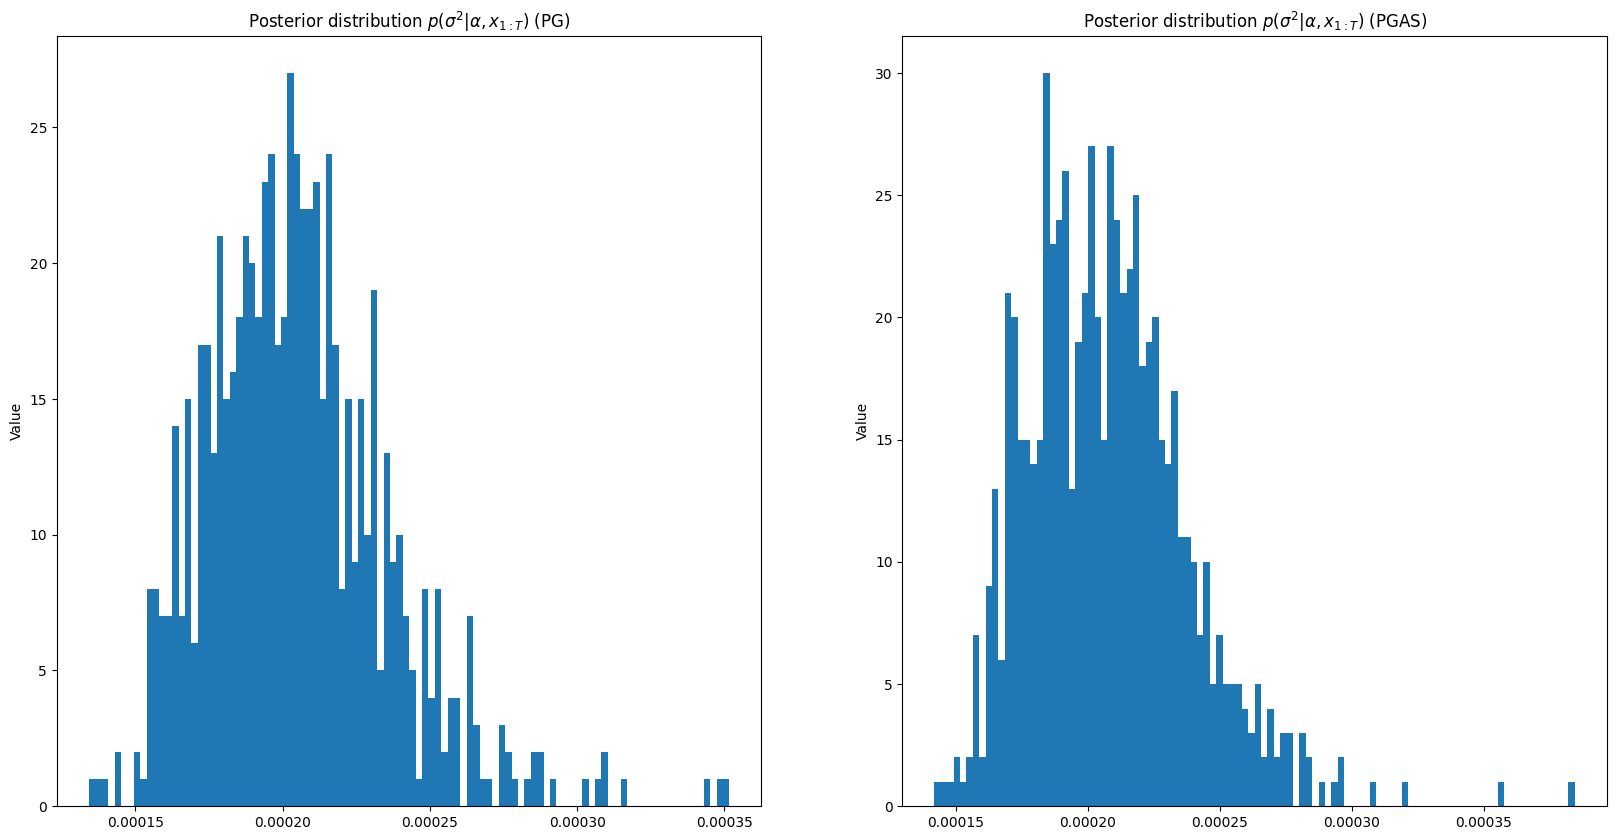

In [54]:
# comparing the parameters obtained with pg and the ones obtained with pgas
fig, axs = plt.subplots(1,2, figsize = (20,10))
axs[0].hist(betas_post_burnin, bins = 100)
#axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Value')
axs[0].set_title('Posterior distribution $p(\\beta |x_{1:T},y_{1:T})$ (PG)')
#axs[1].set_xlabel('Iteration')
axs[1].hist(betas_as_post_burnin, bins = 100)
axs[1].set_ylabel('Value')
axs[1].set_title('Posterior distribution $p(\\beta |x_{1:T},y_{1:T})$ (PGAS)')

fig2, axs2 = plt.subplots(1,2, figsize = (20,10))
axs2[0].hist(sigma_squareds_post_burnin, bins = 100)
#axs2[0].set_xlabel('Iteration')
axs2[0].set_ylabel('Value')
axs2[0].set_title('Posterior distribution $p(\sigma^2|\\alpha,x_{1:T})$ (PG)')
axs2[1].hist(sigma_squareds_as_post_burnin, bins = 100)
#axs2[1].set_xlabel('Iteration')
axs2[1].set_ylabel('Value')
axs2[1].set_title('Posterior distribution $p(\sigma^2|\\alpha,x_{1:T})$ (PGAS)')